In [1]:
# Import necessary libraries
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls /content/drive/MyDrive/final_project_deep_learning/nasdaq_dataset/data_nasdaq_csv/csv

AAL.csv    BDMS.csv   CPRT.csv	 FATE.csv   HOLI.csv	LQDT.csv   OIIM.csv   RMCF.csv	 TCFC.csv
AAME.csv   BDSI.csv   CPRX.csv	 FBIZ.csv   HOLX.csv	LRCX.csv   OIS.csv    RMGN.csv	 TCPC.csv
AAOI.csv   BEAT.csv   CPSI.csv	 FBMS.csv   HOV.csv	LSBK.csv   OKE.csv    RMTI.csv	 TCX.csv
AAON.csv   BEBE.csv   CPSS.csv	 FBP.csv    HQCL.csv	LSCC.csv   OLED.csv   RNST.csv	 TEDU.csv
AAPL.csv   BECN.csv   CRAI.csv	 FCAP.csv   HQY.csv	LSTR.csv   OMAB.csv   RNWK.csv	 TEI.csv
AAVL.csv   BELFB.csv  CREG.csv	 FCBC.csv   HRTX.csv	LTBR.csv   OMCL.csv   ROCK.csv	 TENX.csv
AAWW.csv   BFIN.csv   CRIS.csv	 FCCO.csv   HRZN.csv	LTRE.csv   OMER.csv   ROIC.csv	 TESS.csv
ABCB.csv   BGCP.csv   CRMT.csv	 FCEL.csv   HSIC.csv	LTRPA.csv  OMEX.csv   ROST.csv	 TGA.csv
ABCD.csv   BGFV.csv   CRNT.csv	 FCMGF.csv  HSII.csv	LTRX.csv   OMF.csv    ROYL.csv	 TGEN.csv
ABCO.csv   BGMD.csv   CROX.csv	 FCNCA.csv  HSKA.csv	LULU.csv   OMRNY.csv  RPRX.csv	 TGLS.csv
ABIO.csv   BIDU.csv   CRTN.csv	 FCT.csv    HSON.csv	LUNA.csv   ONB.csv    R

# Task 1.1: Nasdaq multi-feature extension

## Filter Data

In [3]:
# Set the paths for your project
csv_path = '/content/drive/MyDrive/final_project_deep_learning/nasdaq_dataset/data_nasdaq_csv/csv'

In [4]:
stock_symbols_dictionary_path = '/content/drive/MyDrive/final_project_deep_learning/stock_symbols_dictionary.csv'

# Load the CSV file containing company symbols and data
stock_symbols_dictionary_df = pd.read_csv(stock_symbols_dictionary_path)

# Convert 'Market Cap' to numeric, handling errors
stock_symbols_dictionary_df['Market Cap'] = pd.to_numeric(stock_symbols_dictionary_df['Market Cap'], errors='coerce')

# Drop rows with NaN values in the 'Market Cap' column
stock_symbols_dictionary_df = stock_symbols_dictionary_df.dropna(subset=['Market Cap'])

In [5]:
# Filter for companies in the Technology sector
technology_df = stock_symbols_dictionary_df[stock_symbols_dictionary_df['Sector'] == 'Technology']

# Sort the DataFrame by 'Market Cap' in descending order
sorted_technology_df = technology_df.sort_values(by='Market Cap', ascending=False)

# Get the top 30 company symbols
top_30_technology_symbols = sorted_technology_df['Symbol'].head(30).tolist()
top_30_technology_symbols = [symbol.strip().upper() for symbol in top_30_technology_symbols]

# List all CSV files in the specified folder
all_csv_files = [f for f in os.listdir(csv_path) if f.endswith('.csv')]

# Select files that match the top 30 technology symbols
selected_top_30_technology_files = [
    f for f in all_csv_files if os.path.splitext(f)[0].strip().upper() in top_30_technology_symbols
]

# Display the selected files
print("\nSelected CSV files for the top 30 technology symbols:")
print(selected_top_30_technology_files)
print(f"\nTotal number of selected files: {len(selected_top_30_technology_files)}")


Selected CSV files for the top 30 technology symbols:
['MSFT.csv', 'AMAT.csv', 'AMD.csv', 'NXPI.csv', 'NVDA.csv', 'TYL.csv', 'MRVL.csv', 'MPWR.csv', 'PAYX.csv', 'SNPS.csv', 'ADP.csv', 'ON.csv', 'QCOM.csv', 'AAPL.csv', 'GRMN.csv', 'CTSH.csv', 'MU.csv', 'ASML.csv', 'LRCX.csv', 'CSCO.csv', 'MCHP.csv', 'CDNS.csv', 'MSTR.csv', 'ADI.csv', 'ADBE.csv', 'INTU.csv', 'INTC.csv', 'TXN.csv', 'FTNT.csv', 'ADSK.csv']

Total number of selected files: 30


In [ ]:
# Load selected CSV files and create a list to store dataframes
df_list = []
for file in selected_top_30_technology_files:
    file_path = os.path.join(csv_path, file)
    data = pd.read_csv(file_path, on_bad_lines='skip')
    df_list.append(data)

## Preprocess data

In [ ]:
for data in df_list:
        data['Date'] = pd.to_datetime(data['Date'], dayfirst=True, errors='coerce')

In [ ]:
split_date_train = pd.Timestamp('01-01-2020')
split_date_val = pd.Timestamp('01-01-2021')

In [ ]:
df_train_list = []
df_val_list = []
df_test_list = []
for i in range(30):
    cur_df = df_list[i]
    df_train = cur_df.loc[cur_df['Date'] < split_date_train] # Split training
    df_test = cur_df.loc[cur_df['Date'] >= split_date_train] # Split testing
    df_train_list.append(df_train)
    df_test_list.append(df_test)

for i in range(30):
    cur_test_df = df_test_list[i]
    df_test = cur_test_df.loc[cur_test_df['Date'] >= split_date_val] # Split testing
    df_val = cur_test_df.loc[cur_test_df['Date'] < split_date_val] # Split validation
    df_test_list[i] = df_test
    df_val_list.append(df_val)

In [ ]:
from tqdm import tqdm
import numpy as np

# Function to split a dataset into time windows with tqdm progress bar
def create_time_window_samples(df_list, window_size=30):
    X_data = []
    y_data = []

    # Wrap tqdm around the main loop to track progress
    for df in tqdm(df_list, desc="Processing DataFrames"):
        for i in range(0, len(df) - window_size):
            current_feature = []

            # Get a window_size time frame for data features
            for j in range(window_size):
                # Concatenate all 5 features (excluding target 'Open' in this case)
                data_feature = [df.iloc[i + j, k] for k in range(1, 6)]
                current_feature.append(np.array(data_feature))

            # Next value is the label (price of the next day) to be predicted
            data_label = df.iloc[i + window_size, 2]  # Assume 'Open' is at index 2

            # Append new data sample (feature and label) to X_data and y_data
            X_data.append(np.array(current_feature).reshape(window_size, 5))
            y_data.append(data_label)

    return np.array(X_data), np.array(y_data)

# Define the window size
window_size = 30

# Generate training, validation, and test samples with progress bars
X_data_train, y_data_train = create_time_window_samples(df_train_list, window_size)
X_data_val, y_data_val = create_time_window_samples(df_val_list, window_size)
X_data_test, y_data_test = create_time_window_samples(df_test_list, window_size)

# Print confirmation
print("Data samples created for training, validation, and test sets.")

Processing DataFrames: 100%|██████████| 30/30 [00:55<00:00,  1.85s/it]

Data samples created for training, validation, and test sets.


In [ ]:
# Function to normalize data with Min-Max scaling
def min_max_normalize(X_data, y_data=None):
    print("Normalizing data with Min-Max scaling...")
    X_norm = X_data.copy()
    y_norm = y_data.copy() if y_data is not None else None

    for i in range(len(X_data)):
        for j in range(X_data.shape[2]):
            min_feature = np.min(X_data[i][:, j])
            max_feature = np.max(X_data[i][:, j])
            X_norm[i][:, j] = (X_data[i][:, j] - min_feature) / (max_feature - min_feature) if max_feature > min_feature else 0
        if (i+1) % 100 == 0 or i == len(X_data) - 1:  # Print progress every 100 samples
            print(f"Processed normalization for sample {i+1}/{len(X_data)}")

    if y_data is not None:
        for i in range(len(y_data)):
            min_label = np.min(X_data[i][:, 1])
            max_label = np.max(X_data[i][:, 1])
            y_norm[i] = (y_data[i] - min_label) / (max_label - min_label) if max_label > min_label else 0

    print("Normalization complete.")
    return X_norm, y_norm

In [ ]:
# Normalize training, validation, and test data
X_train_norm, y_train_norm = min_max_normalize(X_data_train, y_data_train)
X_val_norm, y_val_norm = min_max_normalize(X_data_val, y_data_val)
X_test_norm, y_test_norm = min_max_normalize(X_data_test, y_data_test)

Normalizing data with Min-Max scaling...
Processed normalization for sample 100/222945
Processed normalization for sample 200/222945
Processed normalization for sample 300/222945
Processed normalization for sample 400/222945
Processed normalization for sample 500/222945
Processed normalization for sample 600/222945
Processed normalization for sample 700/222945
Processed normalization for sample 800/222945
Processed normalization for sample 900/222945
Processed normalization for sample 1000/222945
Processed normalization for sample 1100/222945
Processed normalization for sample 1200/222945
Processed normalization for sample 1300/222945
Processed normalization for sample 1400/222945
Processed normalization for sample 1500/222945
Processed normalization for sample 1600/222945
Processed normalization for sample 1700/222945
Processed normalization for sample 1800/222945
Processed normalization for sample 1900/222945
Processed normalization for sample 2000/222945
Processed normalization for 

## Train with Conv1D

In [ ]:
# Import libraries
import tensorflow as tf
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, BatchNormalization, Dropout, AveragePooling1D

# Build the model architecture
model = tf.keras.Sequential()
model.add(Conv1D(32, kernel_size=3, activation='relu', input_shape=(window_size, 5), padding='same'))
model.add(MaxPooling1D(pool_size=2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(32, kernel_size=3, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1)) # By default: activation='linear', i.e., passing through f(x) = x

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# Compile and train the model with Mean Squared Error loss function
model.summary()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_4 (Conv1D)                    │ (None, 30, 32)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_4 (MaxPooling1D)       │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_5 (Conv1D)                    │ (None, 15, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_5 (MaxPooling1D)       │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 7, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_6 (MaxPooling1D)       │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_7 (Conv1D)                    │ (None, 3, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_7 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │           3,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,225 (51.66 KB)

 Trainable params: 13,225 (51.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 14s 94ms/step - loss: 0.1118 - mse: 0.1118 - val_loss: 0.0179 - val_mse: 0.0179
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 111ms/step - loss: 0.0137 - mse: 0.0137 - val_loss: 0.0148 - val_mse: 0.0148
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 107ms/step - loss: 0.0113 - mse: 0.0113 - val_loss: 0.0159 - val_mse: 0.0159
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 90ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 103ms/step - loss: 0.0109 - mse: 0.0109 - val_loss: 0.0141 - val_mse: 0.0141
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0105 - mse: 0.0105 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0112 - mse: 0.0112 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 95ms/step - loss: 0.0104 - mse: 0.0104 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━

In [ ]:
# evaluate the model
loss, mse = model.evaluate(X_test_norm, y_test_norm, verbose=0)
print('Test loss: %.3f' % loss)
print('Test mse: %.3f' % mse)

Test loss: 0.011
Test mse: 0.011


432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


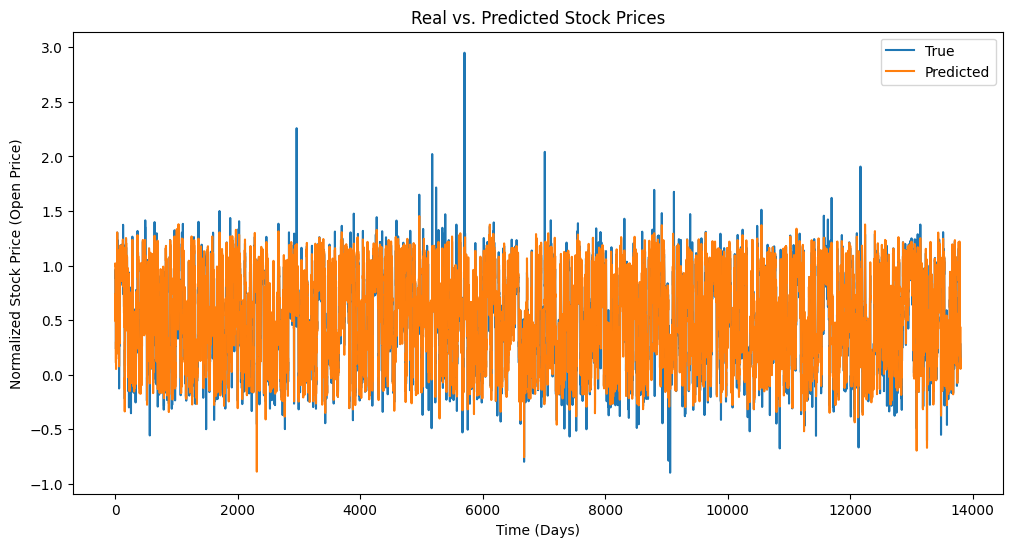

In [ ]:
import matplotlib.pyplot as plt

# plot predictions
yhat = model.predict(X_test_norm)
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm, label='True')
plt.plot(yhat, label='Predicted')
plt.title('Real vs. Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

## Train with LSTM

In [ ]:
from tensorflow.keras.layers import LSTM, Flatten, Dense

# Build the LSTM model architecture
modelLSTM = tf.keras.Sequential()
modelLSTM.add(LSTM(50, return_sequences=True, input_shape=(window_size, 5)))  # First LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Dropout layer for regularization
modelLSTM.add(LSTM(50, return_sequences=False))  # Second LSTM layer with 50 units
modelLSTM.add(Dropout(0.2))  # Another Dropout layer for regularization
modelLSTM.add(Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelLSTM.add(Dense(1))  # Output layer for regression (predicting stock prices)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Compile the model
modelLSTM.summary()
modelLSTM.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelLSTM.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,601 (142.97 KB)

 Trainable params: 36,601 (142.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 79s 693ms/step - loss: 0.0974 - mse: 0.0974 - val_loss: 0.0158 - val_mse: 0.0158
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 74s 683ms/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 80s 737ms/step - loss: 0.0133 - mse: 0.0133 - val_loss: 0.0143 - val_mse: 0.0143
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 75s 675ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 82s 678ms/step - loss: 0.0126 - mse: 0.0126 - val_loss: 0.0145 - val_mse: 0.0145
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 717ms/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0142 - val_mse: 0.0142
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 78s 679ms/step - loss: 0.0129 - mse: 0.0129 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 73s 670ms/step - loss: 0.0117 - mse: 0.0117 - val_loss: 0.0140 - val_mse: 0.0140
Epoch 9/20
109/109 ━━━━━━━━━━━━━

In [ ]:
# evaluate the model
loss, mse = modelLSTM.evaluate(X_test_norm, y_test_norm, verbose=0)
print('Test loss: %.3f' % loss)
print('Test mse: %.3f' % mse)

Test loss: 0.014
Test mse: 0.014


432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 14ms/step


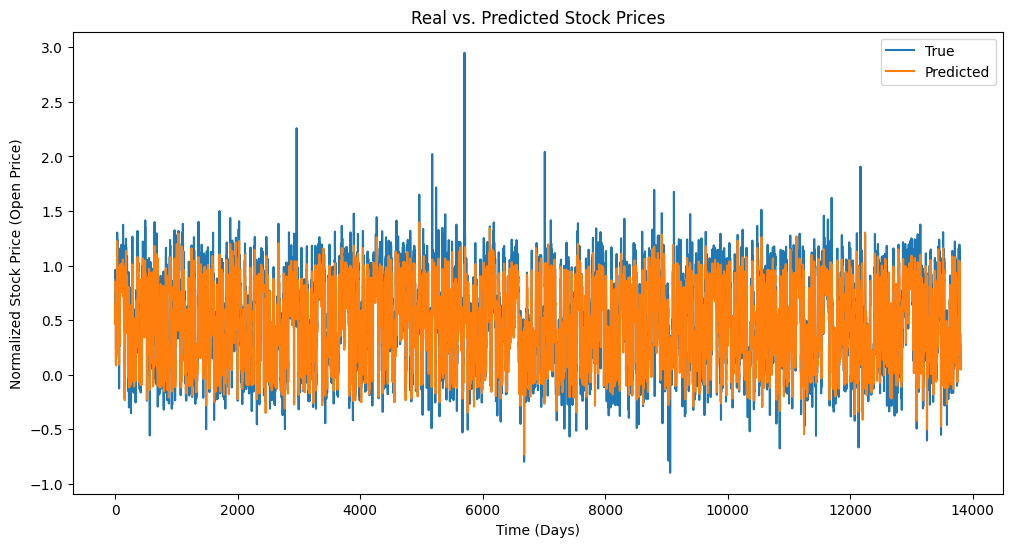

In [ ]:
import matplotlib.pyplot as plt

# plot predictions
yhat = modelLSTM.predict(X_test_norm)
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm, label='True')
plt.plot(yhat, label='Predicted')
plt.title('Real vs. Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

## Train with GRU

In [ ]:
# Build the GRU model architecture
modelGRU = tf.keras.Sequential()
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=True, input_shape=(window_size, 5)))  # First GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Dropout layer for regularization
modelGRU.add(tf.keras.layers.GRU(64, return_sequences=False))  # Second GRU layer with 64 units
modelGRU.add(tf.keras.layers.Dropout(0.2))  # Another Dropout layer for regularization
modelGRU.add(tf.keras.layers.Dense(100, activation='relu'))  # Dense layer with 100 units and ReLU activation
modelGRU.add(tf.keras.layers.Dense(1))  # Output layer for regression (predicting stock prices)

In [ ]:
# Compile the model
modelGRU.summary()
modelGRU.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelGRU.fit(X_train_norm, y_train_norm, validation_data=(X_val_norm,y_val_norm), epochs=20, batch_size=2048, verbose=1)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 64)              │          13,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,193 (176.54 KB)

 Trainable params: 45,193 (176.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 126s 1s/step - loss: 0.1294 - mse: 0.1294 - val_loss: 0.0151 - val_mse: 0.0151
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 133s 1s/step - loss: 0.0149 - mse: 0.0149 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 140s 1000ms/step - loss: 0.0130 - mse: 0.0130 - val_loss: 0.0144 - val_mse: 0.0144
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 116s 1s/step - loss: 0.0124 - mse: 0.0124 - val_loss: 0.0150 - val_mse: 0.0150
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 110s 1s/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0177 - val_mse: 0.0177
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 139s 989ms/step - loss: 0.0114 - mse: 0.0114 - val_loss: 0.0184 - val_mse: 0.0184
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 141s 976ms/step - loss: 0.0120 - mse: 0.0120 - val_loss: 0.0213 - val_mse: 0.0213
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 150s 1s/step - loss: 0.0110 - mse: 0.0110 - val_loss: 0.0193 - val_mse: 0.0193
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━

In [ ]:
# evaluate the model
loss, mse = modelGRU.evaluate(X_test_norm, y_test_norm, verbose=0)
print('Test loss: %.3f' % loss)
print('Test mse: %.3f' % mse)

Test loss: 0.016
Test mse: 0.016


432/432 ━━━━━━━━━━━━━━━━━━━━ 6s 12ms/step


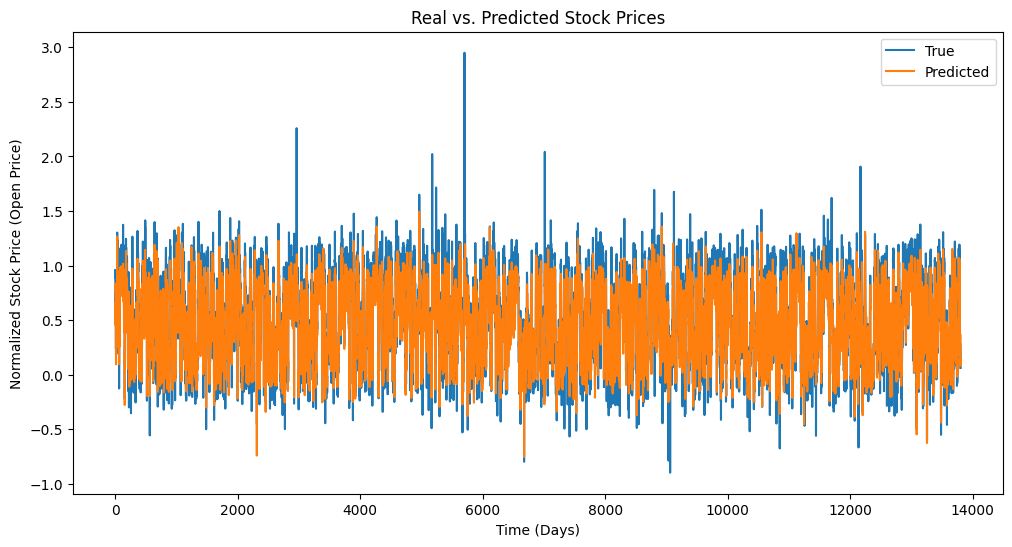

In [ ]:
import matplotlib.pyplot as plt

# plot predictions
yhat = modelGRU.predict(X_test_norm)
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm, label='True')
plt.plot(yhat, label='Predicted')
plt.title('Real vs. Predicted Stock Prices')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

## Test with a random model

Using modelConv1D for prediction
Randomly selected company file: PAYX.csv
432/432 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


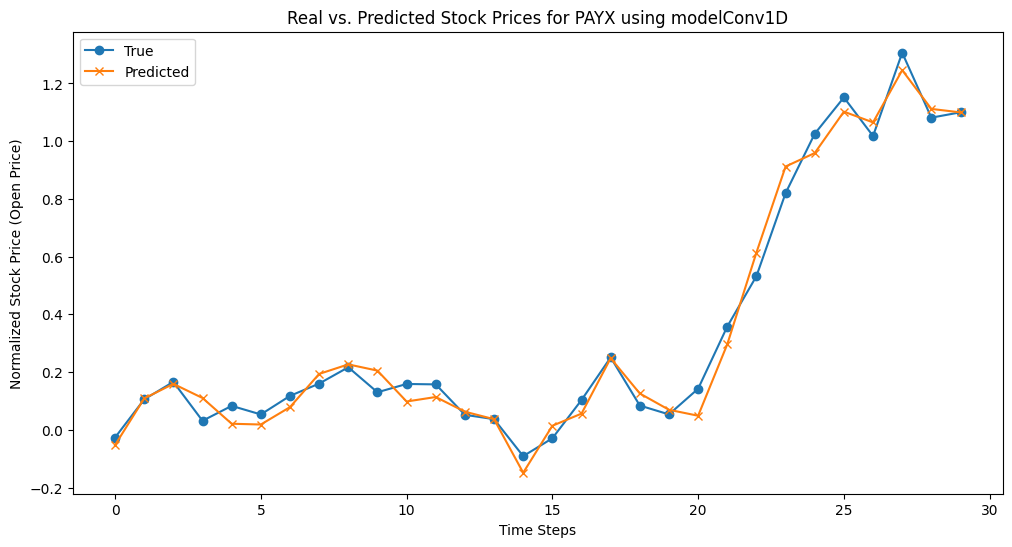

In [ ]:
import random

models = {
    "modelConv1D": model,
    "modelLSTM": modelLSTM,
    "modelGRU": modelGRU
}

# Randomly select a model for prediction
selected_model_name = random.choice(list(models.keys()))
selected_model = models[selected_model_name]
print(f"Using {selected_model_name} for prediction")

# Select a random file from the list
random_file = random.choice(selected_top_30_technology_files)
print(f"Randomly selected company file: {random_file}")

# Plot the results for a random company
random_index = random.randint(0, len(y_test_norm) - 30)

# Make predictions with the selected model
yhat = selected_model.predict(X_test_norm)

# Plot the real and predicted stock prices for the selected company
plt.figure(figsize=(12, 6))
plt.plot(y_test_norm[random_index:random_index + 30], label='True', marker='o')
plt.plot(yhat[random_index:random_index + 30], label='Predicted', marker='x')
plt.title(f"Real vs. Predicted Stock Prices for {random_file.split('.')[0]} using {selected_model_name}")
plt.xlabel("Time Steps")
plt.ylabel("Normalized Stock Price (Open Price)")
plt.legend()
plt.show()

# Task 1.2: Nasdaq kth day forecast

In [ ]:
from tqdm import tqdm
import numpy as np

# Function to split a dataset into time windows with tqdm progress bar
def create_time_window_samples(df_list, window_size=30, k=3):
    X_data_k_day = []
    y_data_k_day = []

    # Wrap tqdm around the main loop to track progress
    for df in tqdm(df_list, desc="Processing DataFrames"):
        # Adjust the loop to stop before the last few rows which cannot form a full window
        for i in range(0, len(df) - window_size - k + 1):
            current_feature = []

            # Get a window_size time frame for data features
            for j in range(window_size):
                # Concatenate all 5 features (excluding target 'Open' in this case)
                data_feature = [df.iloc[i + j, k] for k in range(1, 6)]
                current_feature.append(np.array(data_feature))

            # The target label is now the 'Open' price three days after the last day in the window
            data_label = df.iloc[i + window_size + k - 1, 2]  # Adjust index for the 3-day-ahead 'Open'

            # Append new data sample (feature and label) to X_data and y_data
            X_data_k_day.append(np.array(current_feature).reshape(window_size, 5))
            y_data_k_day.append(data_label)

    return np.array(X_data_k_day), np.array(y_data_k_day)

# Define the window size and days ahead to predict
window_size = 30
days_ahead = 3

# Generate training, validation, and test samples with progress bars
X_train_k_day, y_train_k_day = create_time_window_samples(df_train_list, window_size, days_ahead)
X_val_k_day, y_val_k_day = create_time_window_samples(df_val_list, window_size, days_ahead)
X_test_k_day, y_test_k_day = create_time_window_samples(df_test_list, window_size, days_ahead)

# Normalize the data as before
X_train_k_day_norm, y_train_k_day_norm = min_max_normalize(X_train_k_day, y_train_k_day)
X_val_k_day_norm, y_val_k_day_norm = min_max_normalize(X_val_k_day, y_val_k_day)
X_test_k_day_norm, y_test_k_day_norm = min_max_normalize(X_test_k_day, y_test_k_day)

Processing DataFrames: 100%|██████████| 30/30 [00:43<00:00,  1.44s/it]


Normalizing data with Min-Max scaling...
Processed normalization for sample 100/222885
Processed normalization for sample 200/222885
Processed normalization for sample 300/222885
Processed normalization for sample 400/222885
Processed normalization for sample 500/222885
Processed normalization for sample 600/222885
Processed normalization for sample 700/222885
Processed normalization for sample 800/222885
Processed normalization for sample 900/222885
Processed normalization for sample 1000/222885
Processed normalization for sample 1100/222885
Processed normalization for sample 1200/222885
Processed normalization for sample 1300/222885
Processed normalization for sample 1400/222885
Processed normalization for sample 1500/222885
Processed normalization for sample 1600/222885
Processed normalization for sample 1700/222885
Processed normalization for sample 1800/222885
Processed normalization for sample 1900/222885
Processed normalization for sample 2000/222885
Processed normalization for 

In [ ]:
# Compile and train the model with Mean Squared Error loss function
model.summary()
model.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = model.fit(X_train_k_day_norm, y_train_k_day_norm, validation_data=(X_val_k_day_norm,y_val_k_day_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                      │ (None, 30, 32)              │             512 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d (MaxPooling1D)         │ (None, 15, 32)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_1 (Conv1D)                    │ (None, 15, 32)              │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_1 (MaxPooling1D)       │ (None, 7, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_2 (Conv1D)                    │ (None, 7, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_2 (MaxPooling1D)       │ (None, 3, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_3 (Conv1D)                    │ (None, 3, 32)               │           3,104 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling1d_3 (MaxPooling1D)       │ (None, 1, 32)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │           3,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,225 (51.66 KB)

 Trainable params: 13,225 (51.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - loss: 0.2016 - mse: 0.2016 - val_loss: 0.0736 - val_mse: 0.0736
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0690 - mse: 0.0690 - val_loss: 0.0726 - val_mse: 0.0726
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0692 - mse: 0.0692 - val_loss: 0.0721 - val_mse: 0.0721
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0685 - mse: 0.0685 - val_loss: 0.0726 - val_mse: 0.0726
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0671 - mse: 0.0671 - val_loss: 0.0715 - val_mse: 0.0715
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0665 - mse: 0.0665 - val_loss: 0.0710 - val_mse: 0.0710
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0678 - mse: 0.0678 - val_loss: 0.0712 - val_mse: 0.0712
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0671 - mse: 0.0671 - val_loss: 0.0714 - val_mse: 0.0714
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - l

In [ ]:
# Compile the model
modelLSTM.summary()
modelLSTM.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelLSTM.fit(X_train_k_day_norm, y_train_k_day_norm, validation_data=(X_val_k_day_norm,y_val_k_day_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 30, 50)              │          11,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 30, 50)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 50)                  │          20,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 100)                 │           5,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 36,601 (142.97 KB)

 Trainable params: 36,601 (142.97 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 9s 39ms/step - loss: 0.1469 - mse: 0.1469 - val_loss: 0.0730 - val_mse: 0.0730
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0718 - mse: 0.0718 - val_loss: 0.0732 - val_mse: 0.0732
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0706 - mse: 0.0706 - val_loss: 0.0724 - val_mse: 0.0724
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0701 - mse: 0.0701 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0708 - mse: 0.0708 - val_loss: 0.0719 - val_mse: 0.0719
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0681 - mse: 0.0681 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0683 - mse: 0.0683 - val_loss: 0.0717 - val_mse: 0.0717
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0682 - mse: 0.0682 - val_loss: 0.0720 - val_mse: 0.0720
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/

In [ ]:
# Compile the model
modelGRU.summary()
modelGRU.compile(optimizer= tf.keras.optimizers.Adam(learning_rate=0.01), loss='mse', metrics=['mse'])
history = modelGRU.fit(X_train_k_day_norm, y_train_k_day_norm, validation_data=(X_val_k_day_norm,y_val_k_day_norm), epochs=20, batch_size=2048, verbose=1)

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 30, 64)              │          13,632 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 30, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 64)                  │          24,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 100)                 │           6,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │             101 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 45,193 (176.54 KB)

 Trainable params: 45,193 (176.54 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - loss: 0.1386 - mse: 0.1386 - val_loss: 0.0729 - val_mse: 0.0729
Epoch 2/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0702 - mse: 0.0702 - val_loss: 0.0770 - val_mse: 0.0770
Epoch 3/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0696 - mse: 0.0696 - val_loss: 0.0761 - val_mse: 0.0761
Epoch 4/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0691 - mse: 0.0691 - val_loss: 0.0750 - val_mse: 0.0750
Epoch 5/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0684 - mse: 0.0684 - val_loss: 0.0784 - val_mse: 0.0784
Epoch 6/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0675 - mse: 0.0675 - val_loss: 0.0742 - val_mse: 0.0742
Epoch 7/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0668 - mse: 0.0668 - val_loss: 0.0779 - val_mse: 0.0779
Epoch 8/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - loss: 0.0679 - mse: 0.0679 - val_loss: 0.0757 - val_mse: 0.0757
Epoch 9/20
109/109 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/

## Test with models

In [ ]:
loss_Conv1D, mse_Conv1D = model.evaluate(X_test_k_day_norm, y_test_k_day_norm, verbose=0)
loss_LSTM, mse_LSTM = modelLSTM.evaluate(X_test_k_day_norm, y_test_k_day_norm, verbose=0)
loss_GRU, mse_GRU = modelGRU.evaluate(X_test_k_day_norm, y_test_k_day_norm, verbose=0)

print(f'Conv1D Model - Test loss: {loss_Conv1D:.3f}, Test MSE: {mse_Conv1D:.3f}')
print(f'LSTM Model - Test loss: {loss_LSTM:.3f}, Test MSE: {mse_LSTM:.3f}')
print(f'GRU Model - Test loss: {loss_GRU:.3f}, Test MSE: {mse_GRU:.3f}')

Conv1D Model - Test loss: 0.062, Test MSE: 0.062
LSTM Model - Test loss: 0.063, Test MSE: 0.063
GRU Model - Test loss: 0.062, Test MSE: 0.062


In [ ]:
yhat_Conv1D = model.predict(X_test_k_day_norm)
yhat_LSTM = modelLSTM.predict(X_test_k_day_norm)
yhat_GRU = modelGRU.predict(X_test_k_day_norm)

430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


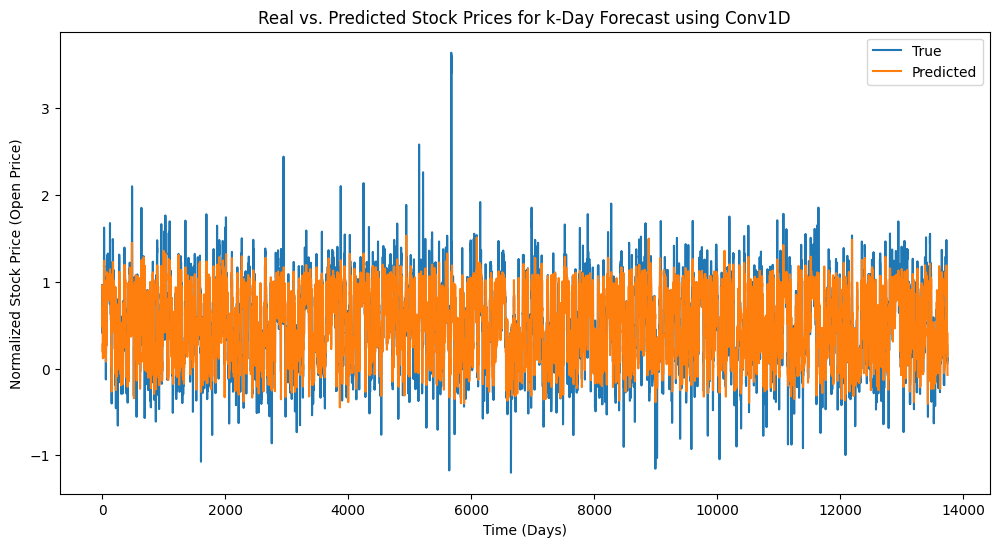

In [ ]:
import matplotlib.pyplot as plt

# Plot the true and predicted stock prices for k-day forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_day_norm, label='True')  # True values for k-day ahead prediction
plt.plot(yhat_Conv1D, label='Predicted')    # Predicted values for k-day ahead
plt.title('Real vs. Predicted Stock Prices for k-Day Forecast using Conv1D')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

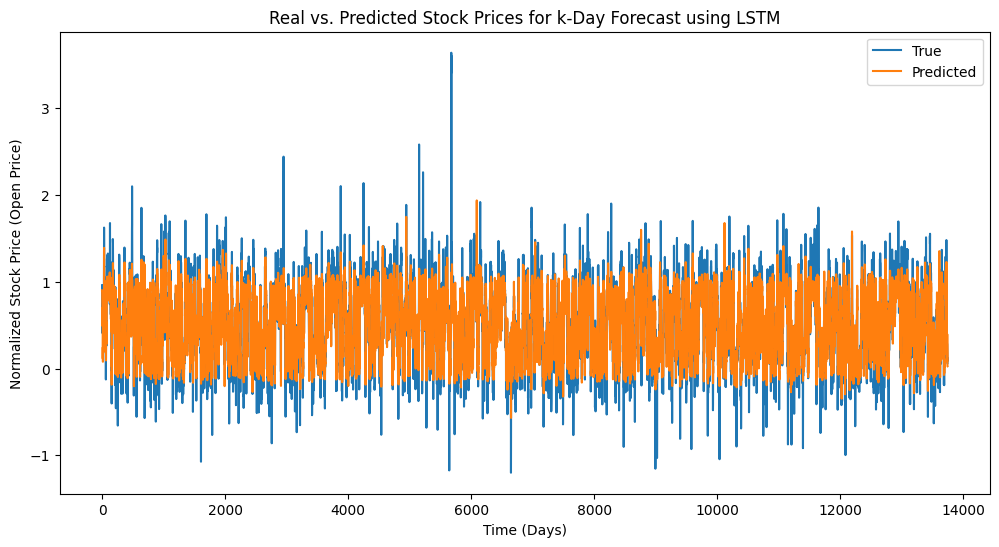

In [ ]:
# Plot the true and predicted stock prices for k-day forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_day_norm, label='True')  # True values for k-day ahead prediction
plt.plot(yhat_LSTM, label='Predicted')    # Predicted values for k-day ahead
plt.title('Real vs. Predicted Stock Prices for k-Day Forecast using LSTM')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

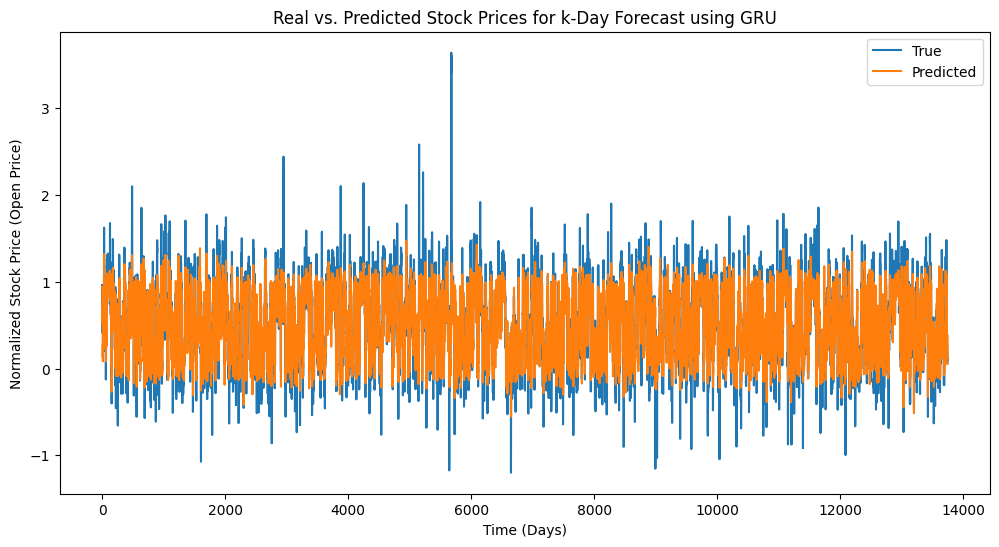

In [ ]:
# Plot the true and predicted stock prices for k-day forecast
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_day_norm, label='True')  # True values for k-day ahead prediction
plt.plot(yhat_GRU, label='Predicted')    # Predicted values for k-day ahead
plt.title('Real vs. Predicted Stock Prices for k-Day Forecast using GRU')
plt.xlabel('Time (Days)')
plt.ylabel('Normalized Stock Price (Open Price)')
plt.legend()
plt.show()

Using modelLSTM for prediction
Randomly selected company file: MCHP.csv
430/430 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


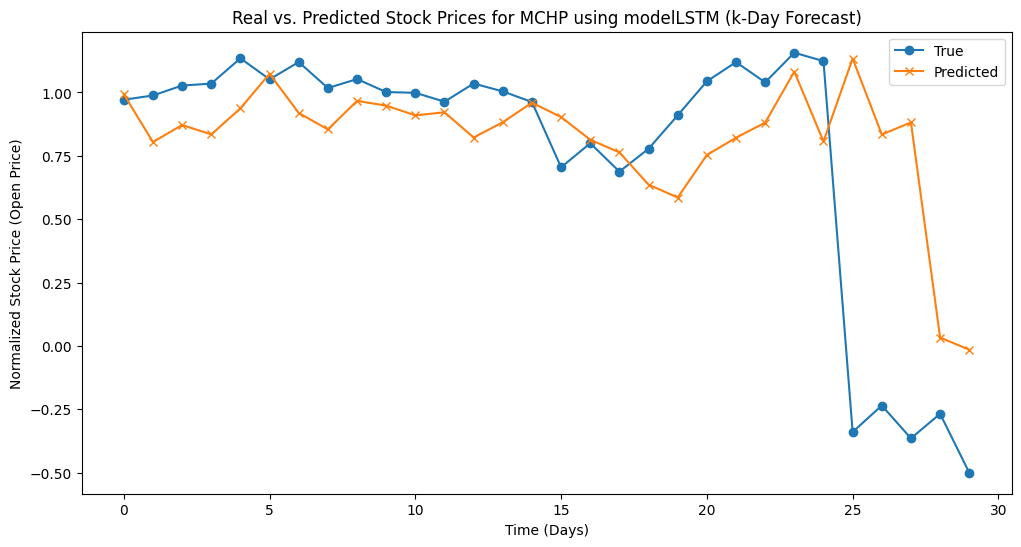

In [ ]:
import random
import matplotlib.pyplot as plt

# Dictionary of models
models = {
    "modelConv1D": model,
    "modelLSTM": modelLSTM,
    "modelGRU": modelGRU
}

# Randomly select a model for prediction
selected_model_name = random.choice(list(models.keys()))
selected_model = models[selected_model_name]
print(f"Using {selected_model_name} for prediction")

# Randomly select a company file from the list of top 30 technology symbols
random_company_index = random.randint(0, len(selected_top_30_technology_files) - 1)
random_file = selected_top_30_technology_files[random_company_index]
print(f"Randomly selected company file: {random_file}")

# Make predictions with the selected model for the k-day forecast
yhat_k_day = selected_model.predict(X_test_k_day_norm)

# Select a random starting index for the 30-day subset
random_index = random.randint(0, len(y_test_k_day_norm) - 30)

# Plot the true and predicted stock prices for the selected company
plt.figure(figsize=(12, 6))
plt.plot(y_test_k_day_norm[random_index:random_index + 30], label='True', marker='o')
plt.plot(yhat_k_day[random_index:random_index + 30], label='Predicted', marker='x')
plt.title(f"Real vs. Predicted Stock Prices for {random_file.split('.')[0]} using {selected_model_name} (k-Day Forecast)")
plt.xlabel("Time (Days)")
plt.ylabel("Normalized Stock Price (Open Price)")
plt.legend()
plt.show()